# 1. detect people

In [1]:
# based on: https://www.youtube.com/watch?v=Pb3opEFP94U&t=813s
# based on: https://colab.research.google.com/drive/1x-eMvFQTLBTr7ho9ZlYkHF0NmyUyAlxT?usp=sharing#scrollTo=Z_pe5XFayoHP

### import libraries

In [380]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.structures import Boxes
from detectron2.structures import Keypoints
from PIL import Image
from SVM import *

import detectron2
import cv2 as cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timeit
import pandas as pd
import random as rnd

### configure detector

In [39]:
def __init__(mode):
    """
    Method initializing a detector with a config file

    :param: mode: Select work mode (Object Detection, Keypoint Extraction)

    :return predictor and cfg objects
    """

    if mode == "OD":
        cfg_od = get_cfg()
        cfg_od.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
        cfg_od.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

        cfg_od.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        cfg_od.MODEL.DEVICE = "cpu"
        predictor_od = DefaultPredictor(cfg_od)

        return predictor_od, cfg_od

    elif mode == "KP":
        cfg_kp = get_cfg()
        cfg_kp.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
        cfg_kp.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

        cfg_kp.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
        cfg_kp.MODEL.DEVICE = "cpu"
        predictor_kp = DefaultPredictor(cfg_kp)

        return predictor_kp, cfg_kp

predictor_od, cfg_od = __init__(mode="OD")

### define function responsible for detected class reduction to one

In [40]:
def chooseOneClassFromAllDetected(initialPredictions, image):
    """
    Method responsible for reducing detected object classes to one particular

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: image to be processed
    """

    classes = initialPredictions["instances"].pred_classes
    scores = initialPredictions["instances"].scores
    boxes = initialPredictions["instances"].pred_boxes

    index_to_keep = (classes == 0).nonzero().flatten().tolist()

    classes_filtered = torch.tensor(np.take(classes.cpu().numpy(), index_to_keep))
    scores_filtered = torch.tensor(np.take(scores.cpu().numpy(), index_to_keep))
    boxes_filtered = Boxes(
        torch.tensor(np.take(boxes.tensor.cpu().numpy(), index_to_keep, axis=0))
    )

    obj = detectron2.structures.Instances(
        image_size=(image.shape[0], image.shape[1])
    )
    obj.set("pred_classes", classes_filtered)
    obj.set("scores", scores_filtered)
    obj.set("pred_boxes", boxes_filtered)

    return obj

### load an image

In [68]:
def loadImage(imagePath, changeColorMode=True):
    """
    Method responsible for loading an image

    :param: imagePath: path to the image
    :param: changeColorMode: change BGR to RGB, useful when using both cv2 and matplotlib

    :return image object
    """

    image = cv2.imread(imagePath)
    if changeColorMode == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

image = loadImage(imagePath="images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg", changeColorMode=True)

### perform detection and make prediction boxes

In [42]:
def performDetection(predictor, image, classReduction):
    """
    Method performing actual detection

    :param: predictor: predictor object
    :param: image: image object
    :param: classReduction: enables class reduction to one


    :return prediction, (optionally) new_predictions and prediction boxes objects
    """

    predictions = predictor(image)

    if classReduction == True:
        new_predictions = chooseOneClassFromAllDetected(initialPredictions=predictions, image=image)
        prediction_boxes = [x.numpy() for x in list(new_predictions.pred_boxes)]

        return predictions, new_predictions, prediction_boxes

    elif classReduction == False:

        return predictions

predictions_od, new_predictions_od, prediction_od_boxes = performDetection(predictor=predictor_od, image=image, classReduction=True)

### make visualization part and extract image with boxes

In [43]:
viz_od = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_od = viz_od.draw_instance_predictions(new_predictions_od.to("cpu"))

image_with_boxes = output_od.get_image()[:, :, ::-1]

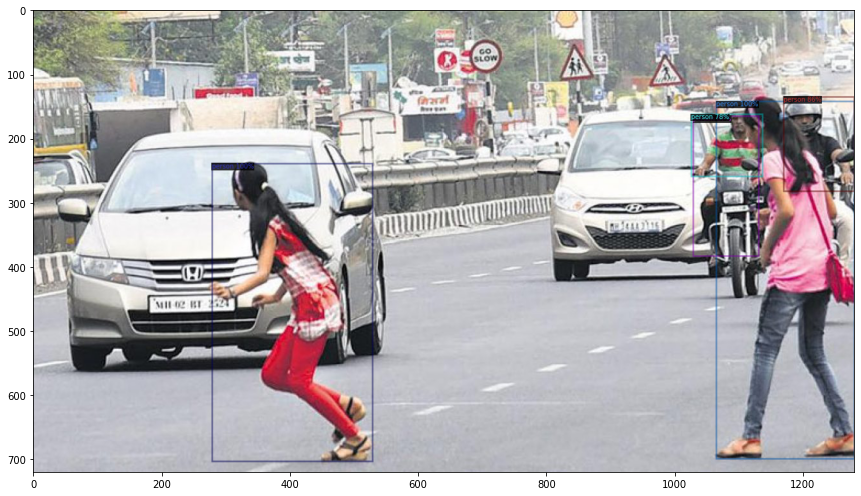

In [44]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_with_boxes)
plt.tight_layout()

# 2. cut part of the image from bounding boxes

In [45]:
# based on: https://stackoverflow.com/questions/68008935/crop-image-using-pred-boxes-coordinates

### define function responsible for cropping part of an image defined by bounding box coordinates

In [46]:
def cropImageByBoundingBox(image, box):
    """
    Function responsible for cropping part of an image defined by bounding box coordinates

    :param: image: image to be processed
    :param: box: numpy array with four box coordinates

    return: cropped image object
    """

    x_top_left = box[0]
    y_top_left = box[1]
    x_bottom_right = box[2]
    y_bottom_right = box[3]

    if type(image) == np.ndarray:
        image = Image.fromarray(image)
    crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))

    if type(image) == Image.Image:
        crop_img = np.array(crop_img)

    return crop_img, (x_top_left, y_top_left)

### perform exemplary cropping

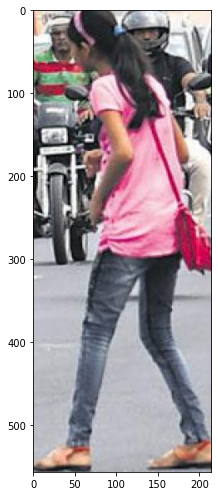

In [282]:
image_index = 0
image_cropped, cropped_image_coordinates = cropImageByBoundingBox(image, prediction_od_boxes[image_index])

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_cropped)
plt.tight_layout()

# 3. make individual skeletonization for each cropped image

### configure another detector (keypoint extraction)

In [48]:
predictor_kp, cfg_kp = __init__(mode="KP")

### make predictions

In [49]:
predictions_kp = performDetection(predictor=predictor_kp, image=image_cropped, classReduction=False)

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


### define function to filter detections to take only the best one

In [50]:
def chooseIndexOfBestKeypointInstanceFromAllDetected(predictions):
    """
    Method responsible for choosing the best (the longest in the sense of euclidean distance) detection instance

    :param: predictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)

    return index of the best (the longest in the sense of euclidean distance) prediction
    """

    # index = np.array([predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(len(predictions["instances"].pred_keypoints.numpy()))])

    length = len(predictions["instances"].pred_keypoints.numpy())
    [predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(length)]

    initial_predictions_all = predictions["instances"].pred_keypoints.numpy()
    index = np.array([])

    for prediction in initial_predictions_all:
        sum = 0
        for i in range(len(prediction)-1):
            sum += np.linalg.norm(prediction[i] - prediction[i+1])
        index = np.append(index, sum)

    if len(index) > 0:
        index_of_value_to_keep = np.argmax(index)
    else:
        index_of_value_to_keep = 0

    return int(index_of_value_to_keep)

### visualize results

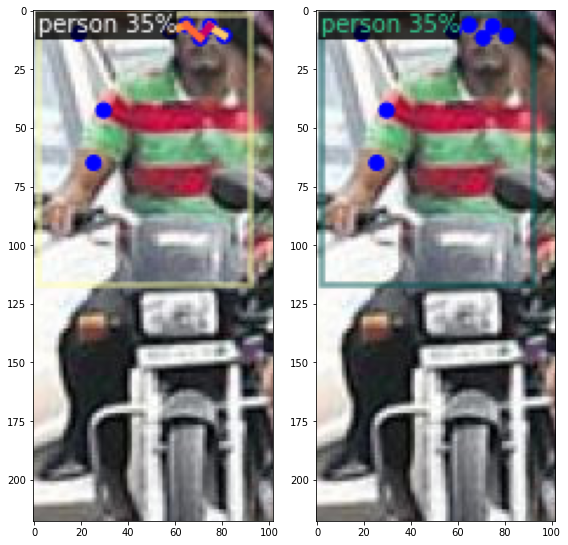

In [51]:
viz_kp = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]
image_skeletonized_dots = output_kp_dots.get_image()[:, :, ::-1]

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_skeletonized)
ax[1].imshow(image_skeletonized_dots)
plt.tight_layout()

In [52]:
# it seems that detecting people and making skeletons on a scene image (the initial one) gives better accuracy skeletonization
# compared to detecting people and making skeletonization on individual people

# 4. project individual masks on the initial picture

### projecion without coordinates correction

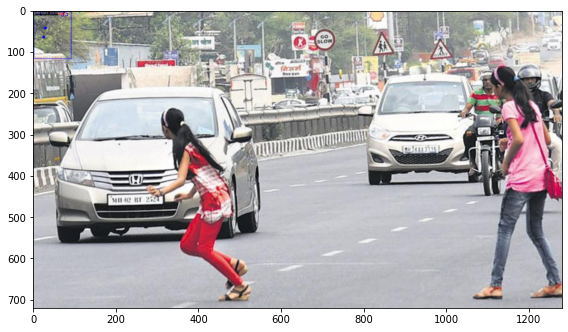

In [53]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

### projecion with coordinates correction

In [54]:
def correctIndividualSkeletonCoordinates(initialPredictions, image, croppedImageCoordinates):
    """
    Method responsible for correction of individual detection (box, keypoints) coordinates to match initial picture position

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: cropped image
    :param: croppedImageCoordinates: cooridnates of the cropped image on the initiial one

    return corrected predictions (box, keypoints)
    """

    boxes = initialPredictions["instances"].pred_boxes
    boxes_filtered = boxes.tensor.cpu().numpy().copy()
    boxes_filtered[:,0] += croppedImageCoordinates[0]
    boxes_filtered[:,2] += croppedImageCoordinates[0]
    boxes_filtered[:,1] += croppedImageCoordinates[1]
    boxes_filtered[:,3] += croppedImageCoordinates[1]

    keypoints = initialPredictions["instances"].pred_keypoints
    keypoints_filtered = keypoints.cpu().numpy().copy()
    keypoints_filtered[:,:,0] += croppedImageCoordinates[0]
    keypoints_filtered[:,:,1] += croppedImageCoordinates[1]

    scores = initialPredictions["instances"].scores

    boxes_filtered = Boxes(torch.tensor(boxes_filtered))
    keypoints_filtered = torch.tensor(keypoints_filtered)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_filtered)
    obj.set("pred_keypoints", keypoints_filtered)
    obj.set("scores", scores)

    return obj

In [55]:
new_preds = correctIndividualSkeletonCoordinates(initialPredictions=predictions_kp, image=image_cropped, croppedImageCoordinates=cropped_image_coordinates)

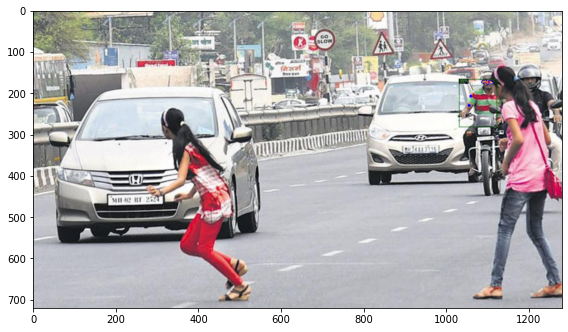

In [56]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)

if index == 0:
    output_kp = viz_kp.draw_instance_predictions(new_preds.to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(new_preds[index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

In [57]:
def combineAllPredictionsTogether(predictionsDict):
    """
    Method responsible for combining all predictions from individual images into one

    :param: predictionsDict: dictionary with predictions for each image

    return one combined prediction instance object
    """

    number_of_people = len(predictionsDict.keys())
    pred_sum = predictionsDict[0]
    boxes_sum = pred_sum.pred_boxes.tensor.cpu().numpy().copy()
    keypoints_sum = pred_sum.pred_keypoints.cpu().numpy().copy()
    scores_sum = pred_sum.scores.cpu().numpy().copy()

    if number_of_people > 1:
        for i in range(1, number_of_people-1):
            pred = predictionsDict[i]
            boxes = pred.pred_boxes.tensor.cpu().numpy().copy()
            keypoints = pred.pred_keypoints.cpu().numpy().copy()
            scores = pred.scores.cpu().numpy().copy()

            boxes_sum = np.vstack([boxes_sum, boxes])
            keypoints_sum = np.vstack([keypoints_sum, keypoints])
            scores_sum = np.append(scores_sum, scores)

    boxes_sum = Boxes(torch.tensor(boxes_sum))
    keypoints_sum = torch.tensor(keypoints_sum)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_sum)
    obj.set("pred_keypoints", keypoints_sum)
    obj.set("scores", scores_sum)

    return obj

# put all together

Execution time was: 66.10395816699747  s


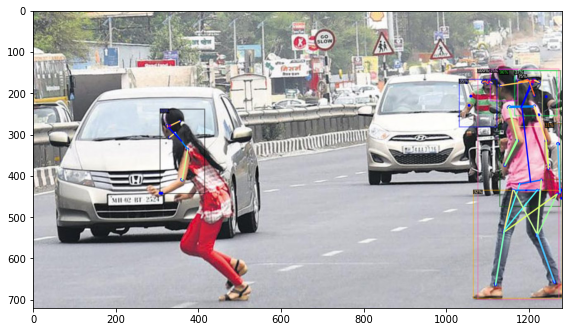

In [58]:
start_time = timeit.default_timer()

# prepare detectors
## initialize OD detector
predictor_od, cfg_od = __init__(mode="OD")

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

# 0. load an image
imagePath = "images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg"
image = loadImage(imagePath=imagePath, changeColorMode=True)

# 1. perform detection and make prediction boxes
(
    predictions_od,
    reduced_predictions_od,
    prediction_od_boxes,
) = performDetection(
    predictor=predictor_od, image=image, classReduction=True
)
## make visualization part
viz_od = Visualizer(
    image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]),
    instance_mode=ColorMode.IMAGE,
)
output_od = viz_od.draw_instance_predictions(reduced_predictions_od.to("cpu"))
image_with_boxes = output_od.get_image()[:, :, ::-1]

number_of_people = len(reduced_predictions_od)
predictions_kp_all = {}
images_kp_all = {}
image_final = image.copy()

for person_index in range(number_of_people):
    # 2. cut part of the image from bounding boxes
    image_cropped, cropped_image_coordinates = cropImageByBoundingBox(
        image=image, box=prediction_od_boxes[person_index]
    )

    # 3. make individual skeletonization for the cropped image
    ## perform detection
    predictions_kp = performDetection(
        predictor=predictor_kp, image=image_cropped, classReduction=False
    )
    ## make visualization part
    viz_kp = Visualizer(
        image_cropped[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]

    # 4. project individual mask on the initial picture
    corrected_predictions = correctIndividualSkeletonCoordinates(
        initialPredictions=predictions_kp,
        image=image_cropped,
        croppedImageCoordinates=cropped_image_coordinates,
    )
    ## make visualization part
    viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions.to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions[index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]
    ## combine all results
    if index == 0:
      predictions_kp_all[person_index] = corrected_predictions.to("cpu")
    else:
      predictions_kp_all[person_index] = corrected_predictions[index].to("cpu")

    images_kp_all[person_index] = image_skeletonized

final_predictions = combineAllPredictionsTogether(predictionsDict=predictions_kp_all)
viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
)
output_sum = viz_kp.draw_instance_predictions(final_predictions.to("cpu"))
image_sum = output_sum.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_sum)
plt.tight_layout()

stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# experiment: detect people all by once and measure time

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Execution time was: 13.695517457999813  s


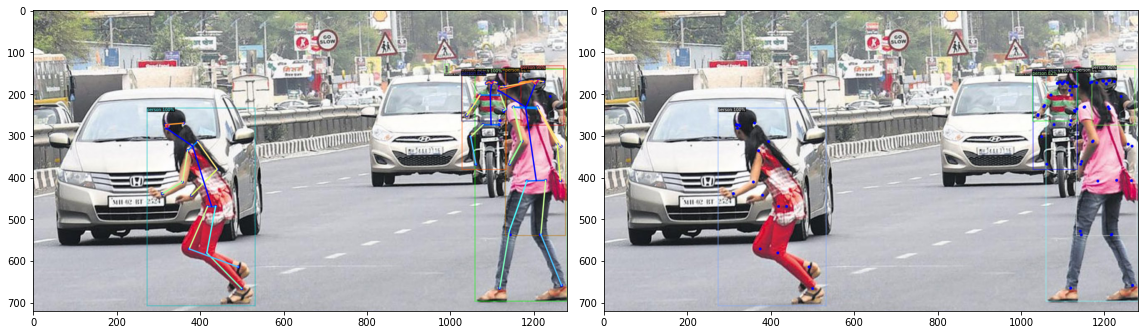

In [69]:
## start measuring execution time
start_time = timeit.default_timer()

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

## make predictions
predictions_kp = performDetection(predictor=predictor_kp, image=image, classReduction=False)

## make visualization part
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
image_final = output_kp.get_image()[:, :, ::-1]
image_final_dots = output_kp_dots.get_image()[:, :, ::-1]

## show resulsts
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(image_final)
ax[1].imshow(image_final_dots)
plt.tight_layout()

## stop measuring execution time
stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# 5. people classification:
- ## entering the road
- ## being on the road
- ## off the interest scope (on a bike, motorcycle, etc.)

### add skeleton data to dataframe for classification

In [284]:
def addPedestrianDataToDataFrame(predictions, index, classification, df=None):
    """
    Method resonsible for creating DataFrame from predictions' keypoints

    :param: predictions: predictions for the whole scene
    :param: index: index of the selected person
    :param: classification: label for the new entry ('stationary', 'in motion')
    :param: df: pandas DataFrame

    return existing df with appended new entry if df is not None and df with new entry only otherwise
    """

    keypoints_x = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,0]
    keypoints_x_normalized = keypoints_x / np.linalg.norm(keypoints_x)
    keypoints_y = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,1]
    keypoints_y_normalized = keypoints_y / np.linalg.norm(keypoints_y)
    # keypoints_score = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,2]

    # keypoint_vector = np.hstack([keypoints_x_normalized, keypoints_y_normalized, keypoints_score])
    keypoint_vector = np.hstack([keypoints_x_normalized, keypoints_y_normalized])

    df_new = pd.DataFrame(keypoint_vector)
    df_new['classification'] = classification
    if df is not None:
        df = df.append(df_new)
        return df
    else:
        return df_new

df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=0, classification="in motion")
df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,classification
0,0.199361,0.201751,0.198166,0.202946,0.225051,0.231026,0.245962,0.223259,0.275237,0.193387,...,0.212033,0.244591,0.246726,0.261671,0.261671,0.323586,0.318248,0.371089,0.342267,in motion


In [321]:
vect = np.array(df)[0][:34]
vect

array([0.19936099648475647, 0.20175078511238098, 0.1981661021709442,
       0.20294567942619324, 0.22505126893520355, 0.23102572560310364,
       0.24596194922924042, 0.22325892746448517, 0.27523690462112427,
       0.193386510014534, 0.2370002120733261, 0.27284711599349976,
       0.2608981430530548, 0.25970324873924255, 0.23341554403305054,
       0.31168124079704285, 0.3063041865825653, 0.15759089589118958,
       0.15332095324993134, 0.1527871936559677, 0.1543884426355362,
       0.1506522297859192, 0.187480628490448, 0.17520450055599213,
       0.22911278903484344, 0.21203292906284332, 0.24459140002727509,
       0.2467263787984848, 0.2616712152957916, 0.2616712152957916,
       0.3235856890678406, 0.3182482421398163, 0.37108904123306274,
       0.3422667682170868], dtype=object)

### read skeleton data

In [222]:
new_column_names = [
    "nose.x",
    "rightEye.x",
    "leftEye.x",
    "rightEar.x",
    "leftEar.x",
    "rightShoulder.x",
    "leftShoulder.x",
    "rightElbow.x",
    "leftElbow.x",
    "rightWrist.x",
    "leftWrist.x",
    "rightHip.x",
    "leftHip.x",
    "rightKnee.x",
    "leftKnee.x",
    "rightAnkle.x",
    "leftAnkle.x",
    "nose.y",
    "rightEye.y",
    "leftEye.y",
    "rightEar.y",
    "leftEar.y",
    "rightShoulder.y",
    "leftShoulder.y",
    "rightElbow.y",
    "leftElbow.y",
    "rightWrist.y",
    "leftWrist.y",
    "rightHip.y",
    "leftHip.y",
    "rightKnee.y",
    "leftKnee.y",
    "rightAnkle.y",
    "leftAnkle.y"
]

new_labels = [
    "annotation.0.points.nose.x",
    "annotation.0.points.rightEye.x",
    "annotation.0.points.leftEye.x",
    "annotation.0.points.rightEar.x",
    "annotation.0.points.leftEar.x",
    "annotation.0.points.rightShoulder.x",
    "annotation.0.points.leftShoulder.x",
    "annotation.0.points.rightElbow.x",
    "annotation.0.points.leftElbow.x",
    "annotation.0.points.rightWrist.x",
    "annotation.0.points.leftWrist.x",
    "annotation.0.points.rightHip.x",
    "annotation.0.points.leftHip.x",
    "annotation.0.points.rightKnee.x",
    "annotation.0.points.leftKnee.x",
    "annotation.0.points.rightAnkle.x",
    "annotation.0.points.leftAnkle.x",
    "annotation.0.points.nose.y",
    "annotation.0.points.rightEye.y",
    "annotation.0.points.leftEye.y",
    "annotation.0.points.rightEar.y",
    "annotation.0.points.leftEar.y",
    "annotation.0.points.rightShoulder.y",
    "annotation.0.points.leftShoulder.y",
    "annotation.0.points.rightElbow.y",
    "annotation.0.points.leftElbow.y",
    "annotation.0.points.rightWrist.y",
    "annotation.0.points.leftWrist.y",
    "annotation.0.points.rightHip.y",
    "annotation.0.points.leftHip.y",
    "annotation.0.points.rightKnee.y",
    "annotation.0.points.leftKnee.y",
    "annotation.0.points.rightAnkle.y",
    "annotation.0.points.leftAnkle.y"
]

In [292]:
df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names

In [293]:
df_skeleton.dropna(inplace=True)
df_skeleton = df_skeleton.head(50)
df_skeleton.head()

,nose.x,rightEye.x,leftEye.x,rightEar.x,leftEar.x,rightShoulder.x,leftShoulder.x,rightElbow.x,leftElbow.x,rightWrist.x,...,rightElbow.y,leftElbow.y,rightWrist.y,leftWrist.y,rightHip.y,leftHip.y,rightKnee.y,leftKnee.y,rightAnkle.y,leftAnkle.y
1,0.755238,0.714824,0.747660,0.626418,0.633996,0.457184,0.507702,0.351097,0.330890,0.282899,...,0.393651,0.368254,0.480952,0.474603,0.557143,0.531746,0.750794,0.714286,0.876190,0.855556
2,0.657049,0.610738,0.700467,0.552848,0.758357,0.512325,0.827824,0.379178,0.891503,0.274977,...,0.319048,0.342857,0.382540,0.490476,0.571429,0.580952,0.746032,0.765079,0.911111,0.920635
3,0.540497,0.476313,0.601302,0.432397,0.675621,0.412129,0.722914,0.310786,0.885063,0.206064,...,0.411111,0.434921,0.555556,0.601587,0.579365,0.576190,0.777778,0.753968,0.906349,0.914286
4,0.547619,0.490667,0.613333,0.433714,0.709714,0.372381,0.801714,0.074476,0.920000,0.017524,...,0.246032,0.382540,0.157143,0.411111,0.504762,0.496825,0.712698,0.711111,0.877778,0.879365
5,0.641497,0.715873,0.692630,0.734467,0.771655,0.436961,0.846032,0.367234,0.864626,0.478798,...,0.385714,0.425397,0.560317,0.536508,0.538095,0.534921,0.712698,0.734921,0.807937,0.901587


### read classification data

In [295]:
df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification['annotation']
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['classification']
df_classification = df_classification.head(50)
df_classification.head()

,classification
1,go-right
2,go-backward
3,go-backward
4,stationary
5,go-right


In [296]:
len(np.array(df_skeleton)[0])
len(np.array(df_skeleton))

50

In [297]:
df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 1, -1)
df_classification.head()

,classification,simplified_classification
1,go-right,-1
2,go-backward,-1
3,go-backward,-1
4,stationary,1
5,go-right,-1


In [298]:
Y = np.array(df_classification['simplified_classification'])
Y

array([-1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [299]:
X = np.array(df_skeleton)

In [277]:
len(df_skeleton)

50

### initialize SVM model

In [387]:
C = 1
max_iter = 1000
epsilon = 0.001
kernel_type = 'linear'

model = SVM(max_iter,kernel_type,C,epsilon)

### assign train data

In [388]:
X_train, y_train = X, Y

### perform model fit

In [389]:
model.performFit(X_train,y_train)

### make prediction

In [390]:
y_hat = model.makePrediction(vect)
y_hat

1